In [1]:
import sys
sys.path.append( '../Model/' )
from torch_geometric.datasets.sbm_dataset import StochasticBlockModelDataset
import torch
from torch_geometric.utils import to_networkx
import networkx as nx
from vq_vae import *
import matplotlib.pyplot as plt
from torch_geometric.utils import negative_sampling


In [2]:
# mat = [[0.9,0.1,0.1,0.1,0.1], [0.1,0.9,0.1,0.1,0.1], [0.1,0.1,0.9,0.1,0.1], [0.1,0.1,0.1,0.9,0.1], [0.1,0.1,0.1,0.1,0.9]]
# size = [10,10,10,10,10]
mat = [[0.9,0.1,0.1,0.1], [0.1,0.9,0.1,0.1], [0.1,0.1,0.9,0.1], [0.1,0.1,0.1,0.9]]
size = [100,100,100,100]
# mat = [[0.8,0.1,0.1], [0.1,0.8,0.1], [0.1,0.1,0.8]]
# size = [500,500,500]
gen = StochasticBlockModelDataset("data", block_sizes=torch.tensor(size), edge_probs=torch.tensor(mat), is_undirected=True)
data = gen.data
G = to_networkx(data, to_undirected=True)
# nx.draw(G, node_color=data.y)
# Fix negative edges
neg_edge_index = negative_sampling(data.edge_index, num_neg_samples=sum(size)*10)
torch.save(neg_edge_index, "data//edge_neg_small_large")
neg_edge_index = torch.load("data//edge_neg_small_large")

Processing...
/Users/liushuhan/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/utils/random.py:78: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756029501/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  row, col = torch.combinations(torch.arange(num_nodes), r=2).t()
Done!
/Users/liushuhan/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/data/storage.py:271: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [3]:
def train_plot_model(prior_beta, beta, lr, epochs=1000):
    hidden_dim = 64
    latent_dim = 64
    num_latent = 30
    prior_alpha  = 1
    input_dim = 15
    torch.manual_seed(2000)
    # Initial data
    data.x = torch.randn(sum(size),input_dim)
    # model
    torch.manual_seed(2000)
    model = sb_vq_vae(input_dim, hidden_dim, latent_dim, num_latent, beta, prior_alpha, prior_beta)

    # move to GPU (if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    # inizialize the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr)

    def train(epoch):
        model.train()
        latent_embedding, quantized_latents, codebook, recon_loss, kl_prior1_loss, pi, v, vq_loss = model(x, edge_index, neg_edge_index=neg_edge_index)
        optimizer.zero_grad()
        loss =   recon_loss +   kl_prior1_loss  + vq_loss # +  0.001 * kl_cat_loss  + 0.001 * torch.abs(kl_kumar_loss)
        loss.backward()
        optimizer.step()
        # for name, params in model.named_parameters():
        #     print(name, eval('model.'+name).grad)
        # for name, parma in model.named_parameters():
        #     print(name, eval('model.'+name).grad, parma.shape)
        return float(loss), latent_embedding, quantized_latents, codebook, recon_loss, kl_prior1_loss, pi, v, vq_loss

    loss_min = torch.tensor([100000]) 
    rec = []
    prior_rec = []
    recon_rec = []
    vq_loss_rec = []

    for epoch in range(1, epochs + 1):
        loss, latent_embedding, quantized_latents, codebook, recon_loss, kl_prior1_loss, pi, v, vq_loss = train(epoch)
        rec.append(loss)
        prior_rec.append(float(kl_prior1_loss))
        recon_rec.append(float(recon_loss))
        vq_loss_rec.append(float(vq_loss))
        # for name, param in model.named_parameters():
        #     print(name, eval('model.'+name).grad)
        if loss < loss_min:
            loss_min = loss
            model.eval()
            latent_embedding_min, quantized_latents_min, codebook_min, recon_loss_min, kl_prior1_loss_min, pi_min, v_min, vq_loss_min = model(x, edge_index, neg_edge_index=neg_edge_index)

        if epoch % 100 == 0:
            print('Epoch:{:03d}, loss:{:.4f}'.format(epoch, loss))
            # print(quantized_latents[0,:])
            # for p in model.parameters():
            #     print(p[:,0])
    plt.plot(prior_rec)
    plt.plot(recon_rec)
    plt.plot(vq_loss_rec)
    model.eval()
    _, color = torch.unique(torch.sum(torch.round(quantized_latents_min, decimals=4), dim=1), return_inverse=True)
    return prior_rec, recon_rec, vq_loss_rec, color
    
def purity(color, label):
    pur = torch.zeros(torch.max(color)+1, torch.max(label)+1)
    for i in range(torch.max(color)+1):
        for j in range(torch.max(label)+1):
            pur[i,j] = torch.sum((color==i) & (label==j)) / torch.sum(color==i)
    return pur



In [4]:
lr = 1e-2
epochs = 1000

/Users/liushuhan/opt/anaconda3/lib/python3.9/site-packages/torch/distributions/distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


Epoch:100, loss:2.7854
Epoch:200, loss:2.3285
Epoch:300, loss:2.1874
Epoch:400, loss:2.1050
Epoch:500, loss:2.0526
Epoch:600, loss:2.0474
Epoch:700, loss:2.0458
Epoch:800, loss:2.0448
Epoch:900, loss:2.0432
Epoch:1000, loss:2.0428
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])
tensor(6)
1.2501431703567505 0.7751522660255432 0.017465075477957726


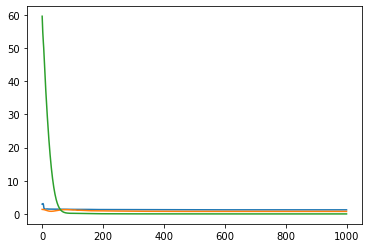

In [5]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=0.5, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[len(prior_rec)-1], recon_rec[len(prior_rec)-1], vq_loss_rec[len(prior_rec)-1])

Epoch:100, loss:2.5083
Epoch:200, loss:2.0047
Epoch:300, loss:1.8307
Epoch:400, loss:1.7389
Epoch:500, loss:1.6965
Epoch:600, loss:1.6530
Epoch:700, loss:1.6495
Epoch:800, loss:1.6484
Epoch:900, loss:1.6482
Epoch:1000, loss:1.6480
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])
tensor(7)
0.855394184589386 0.774702250957489 0.017886416986584663


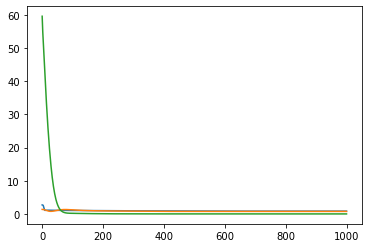

In [6]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=1, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[len(prior_rec)-1], recon_rec[len(prior_rec)-1], vq_loss_rec[len(prior_rec)-1])

Epoch:100, loss:2.3722
Epoch:200, loss:1.8866
Epoch:300, loss:1.6848
Epoch:400, loss:1.5880
Epoch:500, loss:1.5319
Epoch:600, loss:1.5088
Epoch:700, loss:1.5077
Epoch:800, loss:1.5072
Epoch:900, loss:1.5070
Epoch:1000, loss:1.5069
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])
tensor(4)
0.711845338344574 0.776593804359436 0.018465764820575714


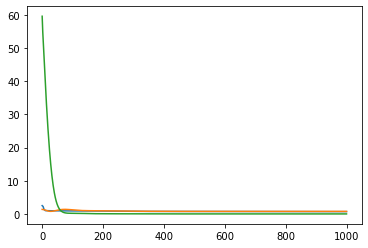

In [7]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=1.5, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:2.2970
Epoch:200, loss:1.8922
Epoch:300, loss:1.6454
Epoch:400, loss:1.5736
Epoch:500, loss:1.5525
Epoch:600, loss:1.5447
Epoch:700, loss:1.5165
Epoch:800, loss:1.5160
Epoch:900, loss:1.5158
Epoch:1000, loss:1.5157
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])
tensor(4)
0.7206194400787354 0.7767156958580017 0.018404118716716766


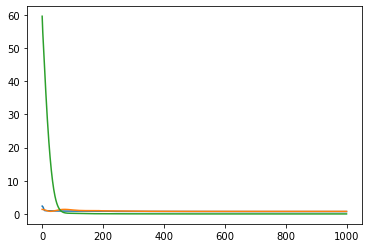

In [8]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=2.0, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:2.3201
Epoch:200, loss:1.7133
Epoch:300, loss:1.4895
Epoch:400, loss:1.4199
Epoch:500, loss:1.4047
Epoch:600, loss:1.4034
Epoch:700, loss:1.4030
Epoch:800, loss:1.4026
Epoch:900, loss:1.4025
Epoch:1000, loss:1.4024
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])
tensor(4)
0.6067747473716736 0.7768415212631226 0.018760699778795242


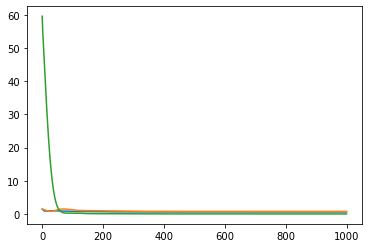

In [9]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=5.0, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:2.1254
Epoch:200, loss:1.7079
Epoch:300, loss:1.4835
Epoch:400, loss:1.4125
Epoch:500, loss:1.4006
Epoch:600, loss:1.3991
Epoch:700, loss:1.3987
Epoch:800, loss:1.3984
Epoch:900, loss:1.3983
Epoch:1000, loss:1.3983
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])
tensor(4)
0.6027565002441406 0.7770819664001465 0.01843133568763733


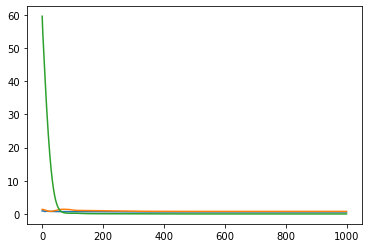

In [10]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=10.0, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:2.2809
Epoch:200, loss:1.8401
Epoch:300, loss:1.6434
Epoch:400, loss:1.5755
Epoch:500, loss:1.5645
Epoch:600, loss:1.5630
Epoch:700, loss:1.5622
Epoch:800, loss:1.5621
Epoch:900, loss:1.5620
Epoch:1000, loss:1.5620
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])
tensor(10)
0.7747653722763062 0.7726145386695862 0.014669027179479599


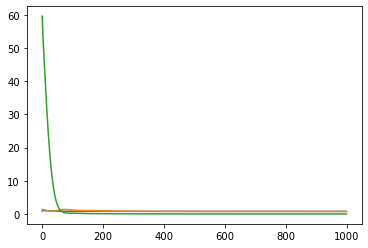

In [11]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=20, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:3.2114
Epoch:200, loss:2.7861
Epoch:300, loss:2.6441
Epoch:400, loss:2.5792
Epoch:500, loss:2.5613
Epoch:600, loss:2.5585
Epoch:700, loss:2.5570
Epoch:800, loss:2.5567
Epoch:900, loss:2.5567
Epoch:1000, loss:2.5566
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])
tensor(16)
1.7774816751480103 0.7686353921890259 0.010526794008910656


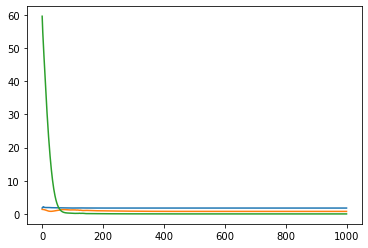

In [14]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=100, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:4.8939
Epoch:200, loss:4.5902
Epoch:300, loss:4.4132
Epoch:400, loss:4.3367
Epoch:500, loss:4.3152
Epoch:600, loss:4.3117
Epoch:700, loss:4.3115
Epoch:800, loss:4.3114
Epoch:900, loss:4.3107
Epoch:1000, loss:4.3106
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])
tensor(17)
3.530191659927368 0.7702792882919312 0.010146602056920528


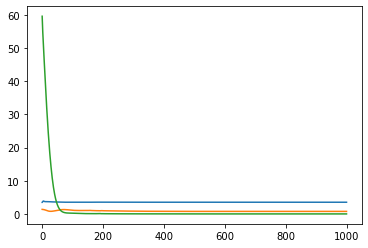

In [15]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=10000, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, data.y))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])